# Basic Hand movements EMG Inferential Statistics
To support our hypothesis that there is a baseline signal for each grip accross all subjects, we must investigate the null hypothesis that each subject deviates too far from whatever baseline that can be calcuated. 

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import matplotlib.pyplot as plt

# read in envelope_df and drop weird columns
df_envelope = pd.read_csv('envelope_df')
df_envelope = df_envelope.drop('Unnamed: 0', axis=1)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## calculating a baseline using the mean
by averageing similar signals we can establish a first attempt at a baseline.

In [2]:
#lets start with subject female_1 with channel 1 signals
female_1 = df_envelope.loc[df_envelope['subject'] == 'female_1']
#average signals based on grip_channel
female1_mean = female_1.groupby('grip_channel').mean()
#select out channel 1
female1_ch1_mean = female1_mean.loc[female1_mean['channel'] == 1]

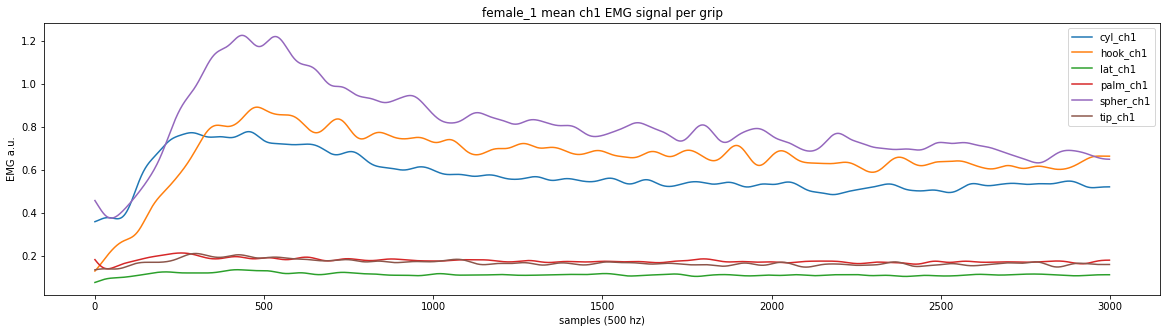

In [3]:
plt.figure(figsize=(20,5))
#plot each signal in the df by iterating over the rows
for x,y in female1_ch1_mean.iloc[:,:3000].iterrows():
    plt.plot(np.array(y))
    
plt.xlabel('samples (500 hz)')
plt.ylabel('EMG a.u.')
plt.title('female_1 mean ch1 EMG signal per grip')
plt.legend(female1_ch1_mean.index)

This is promising, but the mean signal isn't enough to capture the nuances in the readings. In order to see how similar the average signals are, we should compute a confidence interval and see if there is significan overlap.

In [4]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    
    "calculates the mean as well as the top and bottom values of the confidence interval"
    'data = a list or array of data'
    'confidence = size of confidence interval. default is 95%'
    
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

def graph_signals(list_of_mean, list_of_bottom, list_of_top, label, num_of_samples=3000):
    
    "plot mean signal for all observations plus confidence interval"
    "list_of_mean = a list of  signals to plot"
    "list_of_bottom = list of values at bottom of 95% confidence interal of corresponding to list_of_mean"
    "list_of_top = list of values at top of 95% confidence interal of corresponding to list_of_mean"
    "num_of_samples = len of each array in list_of_mean. necessary to set fill between conf inter"
    "NOTE: MUST BE PASSED LISTS. IF YOU DONT PASS LISTS IT WILL DESTROY YOUR MEMORY"

    for x in list_of_mean:
        plt.plot(x, label=label)
    #plot confidence interval for all observations of female_1 channel 1
    for y1, y2 in zip(list_of_bottom, list_of_top):
        plt.plot(y1, c='r', alpha=0.5, linestyle='--')
        plt.plot(y2, c='r', alpha=0.5, linestyle='--')
        x = np.arange(0,num_of_samples,1)
        plt.fill_between(x,y1,y2,alpha=0.5)

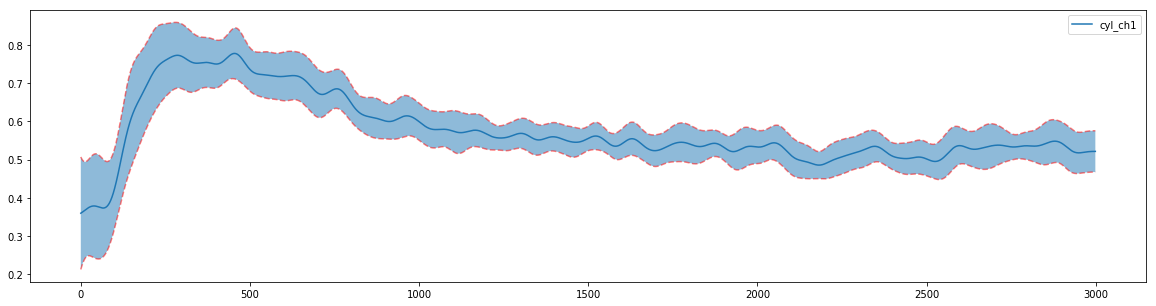

In [5]:
plt.figure(figsize=(20,5))

#lets apply these functions to one signal group: subject female_1 grip cyl channel 1
f1_cyl_ch1 = female_1.loc[female_1['grip_channel'] == 'cyl_ch1']

#lists to hold the calculated mean and confidence interval for each column of data. should be 3000 long each
means = []
bottoms = []
tops = []
for column in f1_cyl_ch1.iloc[:,:3000]:
    #calculate the mean and interval for each column
    mean, bottom, top = mean_confidence_interval(np.array(f1_cyl_ch1[column]))
    means.append(mean)
    bottoms.append(bottom)
    tops.append(top)
#graph lists     
graph_signals([means], [bottoms], [tops],label='cyl_ch1', num_of_samples=3000)

plt.legend()

we can see that after initial activation, the signal seems to stabilize within a range of about 0.2 activity units. Lets try the same technique on the rest of the signals.

In [6]:
#list of grip_name, df tuples
grips_female_1 = [x for x in female_1.groupby(female_1['grip_channel'])]

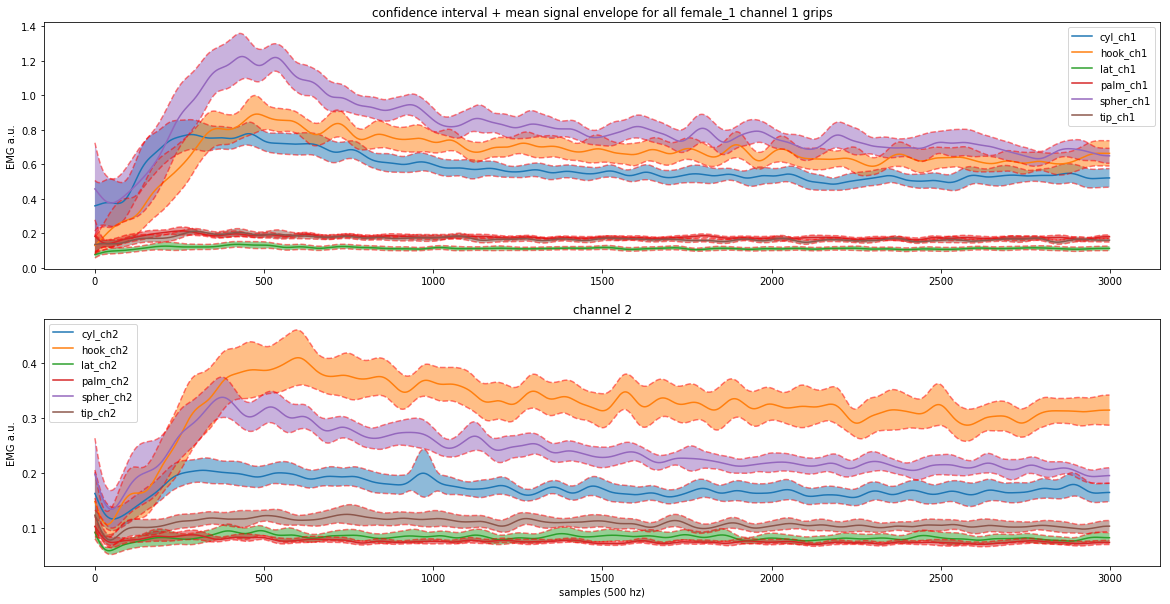

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

#graph all channel 1 signals for female_!
for x, y in grips_female_1[::2]:
    means = []
    bottoms = []
    tops = []
    #caluclate over only numerical columns and exclude categorical columns
    for column in y.iloc[:,:3000]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=3000)

plt.title('confidence interval + mean signal envelope for all female_1 channel 1 grips')
plt.ylabel('EMG a.u.')
plt.legend()

#again for channel 2
plt.subplot(2,1,2)

for x, y in grips_female_1[1::2]:
    means = []
    bottoms = []
    tops = []
    for column in y.iloc[:,:3000]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=3000)

plt.title('channel 2')
plt.xlabel('samples (500 hz)')
plt.ylabel('EMG a.u.')
plt.legend()



## Considering fit of mean signal per group between subjects
Are the signals for grips per channel similar across the subject population?

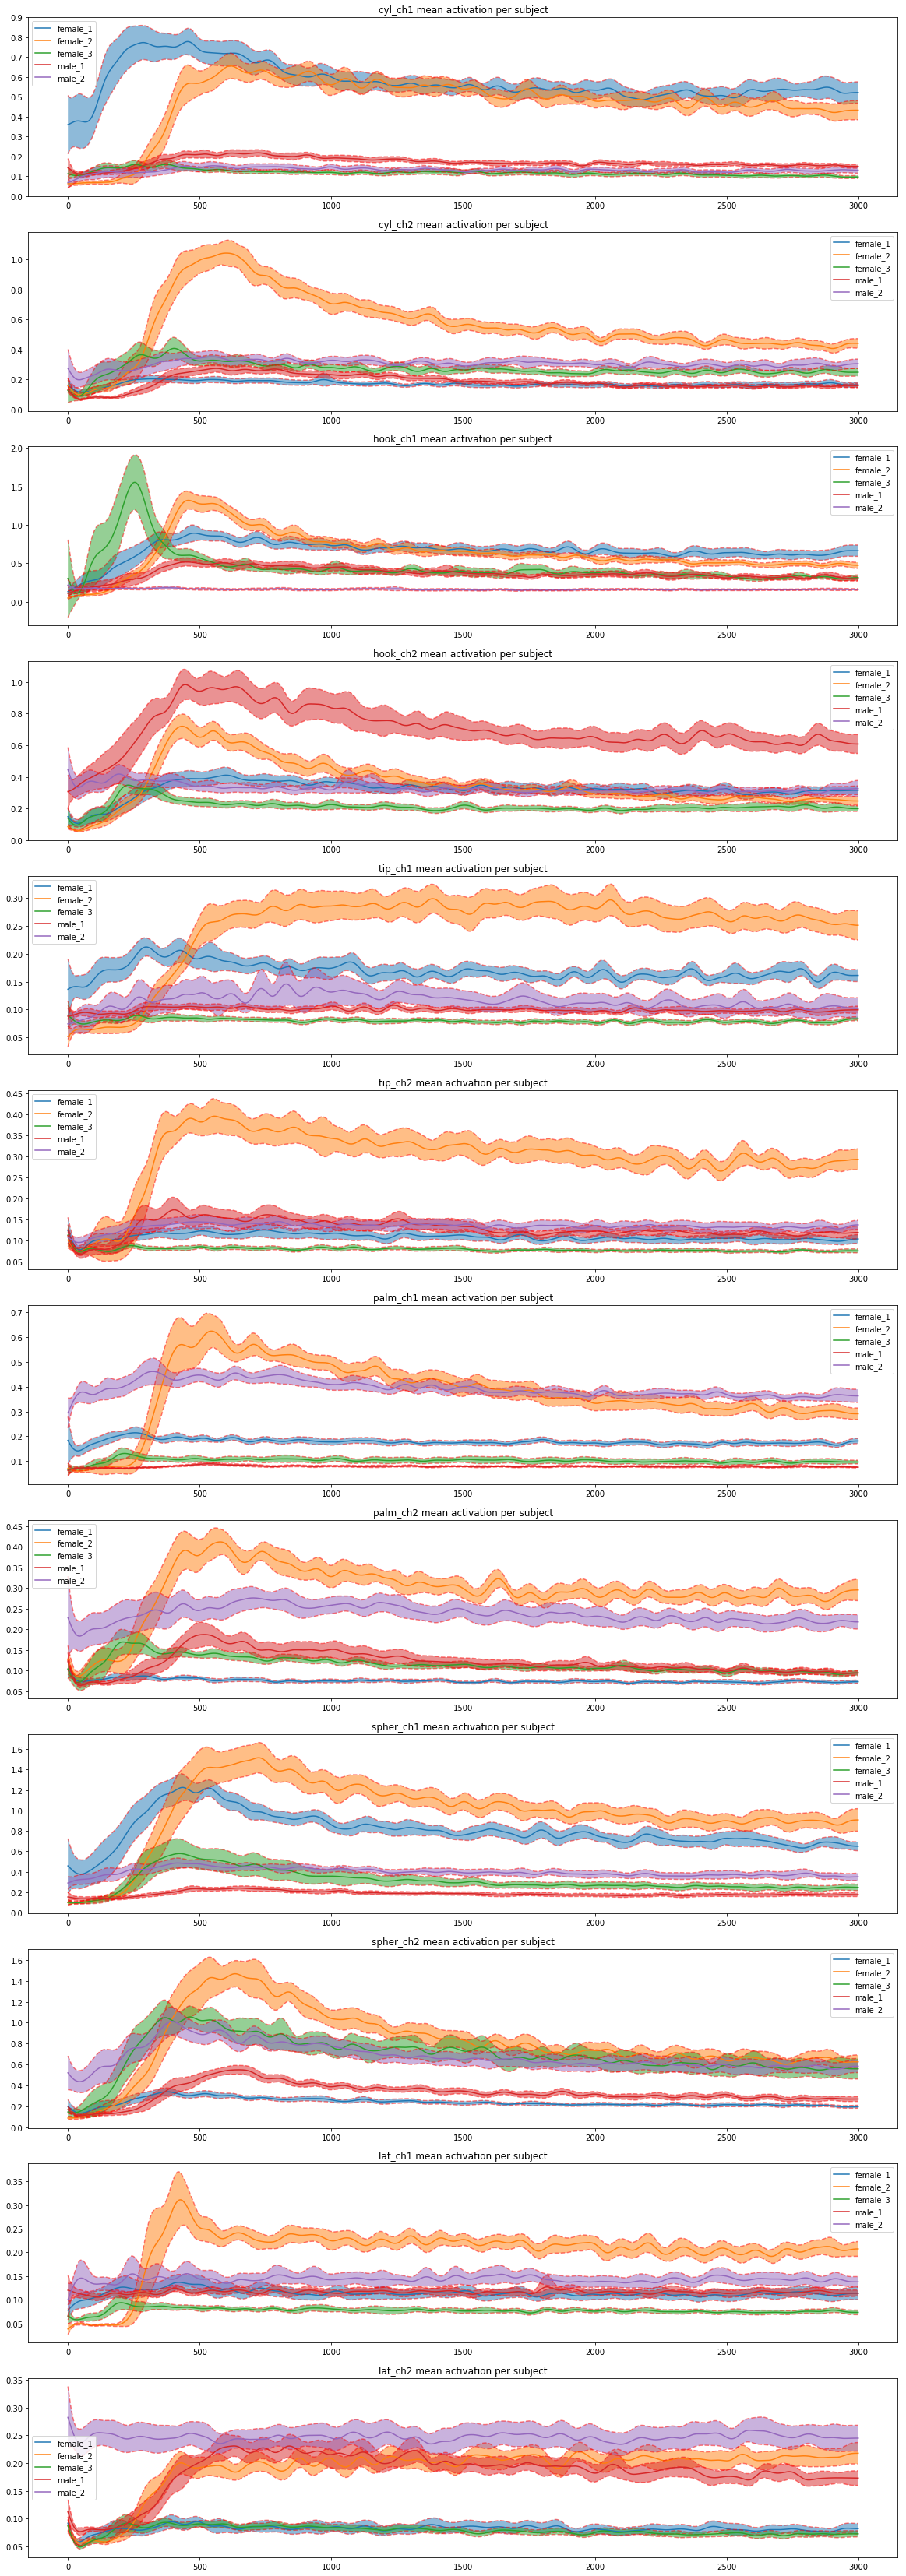

In [8]:
grip_channels = df_envelope['grip_channel'].unique()

subplot = 1

plt.figure(figsize=(20,60))

#loop over each grip
for i in grip_channels:
    grip_df = df_envelope.loc[df_envelope['grip_channel'] == i]
    #group by subject
    gripby_subject = [z for z in grip_df.groupby(grip_df['subject'])]
    plt.subplot(12, 1, subplot)
    #loop over and plot each subjects baseline for that grip
    for x, y in gripby_subject:
        means = []
        bottoms = []
        tops = []
        #caluclate mean and conf int for each column
        for column in y.iloc[:,:3000]:
            mean, bottom, top = mean_confidence_interval(np.array(y[column]))
            means.append(mean)
            bottoms.append(bottom)
            tops.append(top)
            
        graph_signals([means], [bottoms], [tops], label= x, num_of_samples=3000)
        plt.title('{} mean activation per subject'.format(i))
        plt.legend()
    subplot += 1

This is less promising to see. Due to the fact that speed and force are not a constant between readings within each `grip_channel`, we can see that there is a large amount of variation within each channel, and with some variables unaccounted for there is not much to explain the differences. Just to be sure, let us calculate a moving p-value using an ANOVA test to compare the signals within each `grip_channel` to see if the differences are significant, although they already appear to be.

## ANOVA test
Using a moving ANOVA test, we can observed where the samples per grip_channel become statistically unsimilar. 

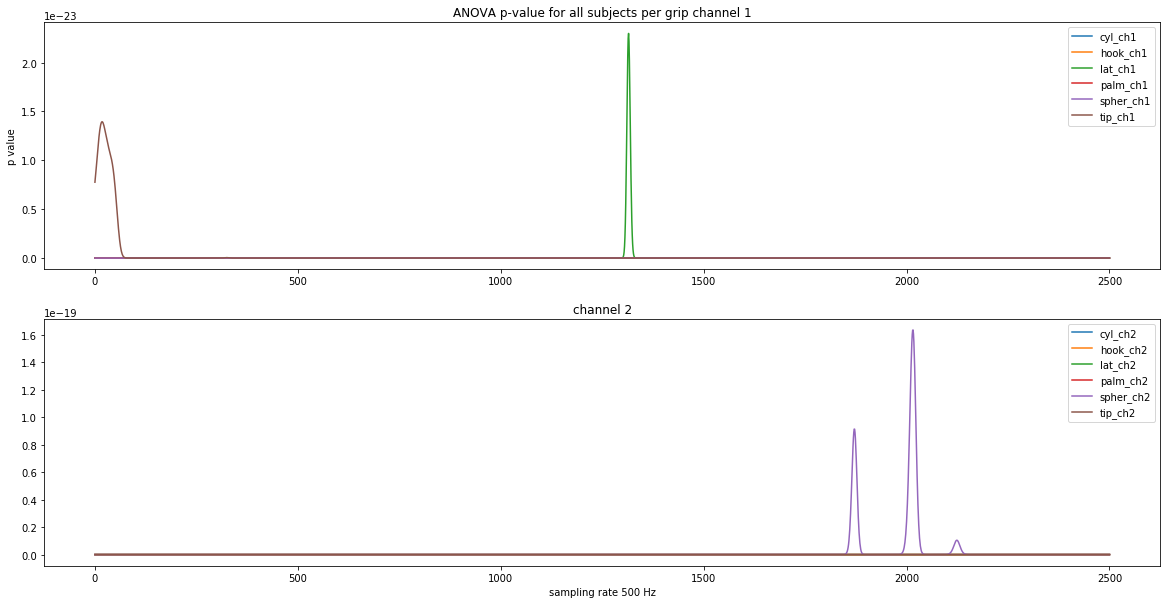

In [9]:
#group by grip channel
grips_all = [x for x in df_envelope.groupby(df_envelope['grip_channel'])]

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

#loop over channel 1 grips
for x, y in grips_all[::2]:
    #group by subject
    gripby_subject = [z for z in y.groupby(y['subject'])]
    # store each corresponding column of each 5 subjects in nested list
    total_arrays = []
    column = 499
    #loop over all columns
    while column <= 2999:
        #store corresponding column from each subject one by one
        array_list = []
        for subject, data in gripby_subject:
            array_list.append(np.array(data['{}'.format(column)]))
        total_arrays.append(array_list)
        column += 1
    #store p values per grip here
    p_values = []
    #calculate p-value for each column of the 5 subjects
    for i in total_arrays:
        one, two, three, four, five = i
        f, p = sp.stats.f_oneway(one, two, three, four, five)
        p_values.append(p)
    #plot
    plt.plot(p_values, label=x)

plt.title('ANOVA p-value for all subjects per grip channel 1')
plt.ylabel('p value')
plt.legend()

#do it again for channel 2
plt.subplot(2,1,2)

for x, y in grips_all[1::2]:
    gripby_subject = [z for z in y.groupby(y['subject'])]
    total_arrays = []
    column = 499
    while column <= 2999:
        array_list = []
        for subject, data in gripby_subject:
            array_list.append(np.array(data['{}'.format(column)]))
        total_arrays.append(array_list)
        column += 1
    p_values = []
    for i in total_arrays:
        one, two, three, four, five = i
        f, p = sp.stats.f_oneway(one, two, three, four, five)
        p_values.append(p)
    plt.plot(p_values, label=x)
    
plt.title('channel 2')
plt.xlabel('sampling rate 500 Hz')
plt.legend()

This ANOVA tests shows that each average signal per subject within grip groups is for the most part statistically significant in its differences. Note that I removed the first second of samples (500) to avoid having the active signals scale being hidden by the resting and intital activation samples, which where overlapping greatly. Looking at the overall baseline for each grip shows that while the majority of the signals within in group are statistically significant, the baseline is still a decent description for the grip overall across all populations
## Baseline mean signal with confidence interval across all populations per grip

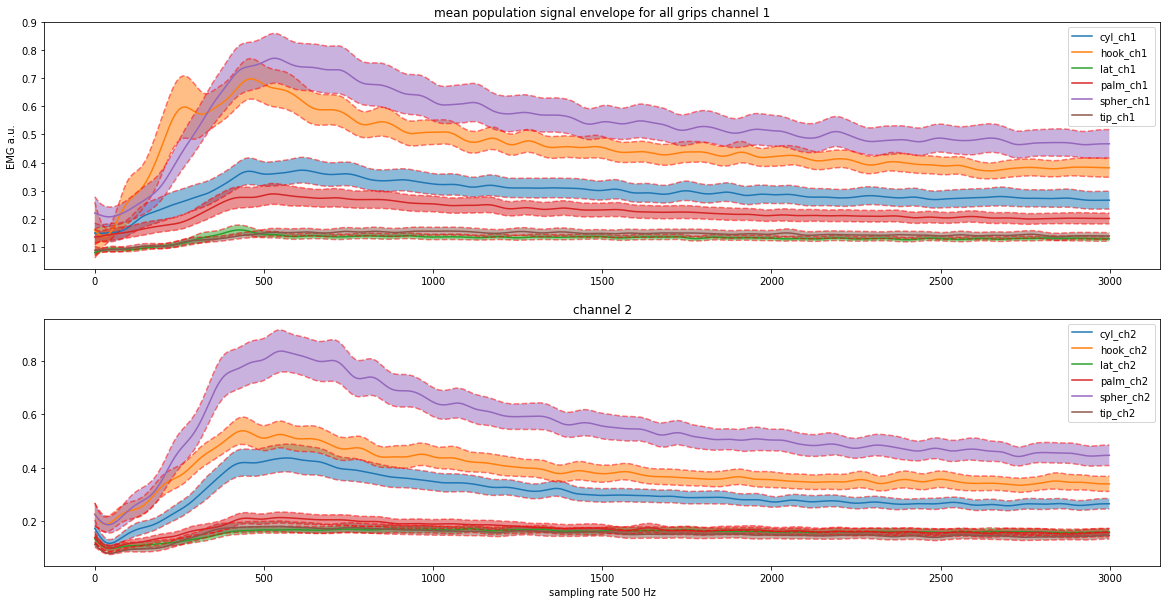

In [10]:

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

#same process as above, but this time aggregate across all subjects per grip
for x, y in grips_all[::2]:
    means = []
    bottoms = []
    tops = []
    for column in y.iloc[:,:3000]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=3000)

plt.title('mean population signal envelope for all grips channel 1')
plt.ylabel('EMG a.u.')
plt.legend()


plt.subplot(2,1,2)

for x, y in grips_all[1::2]:
    means = []
    bottoms = []
    tops = []
    for column in y.iloc[:,:3000]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=3000)

plt.title('channel 2')
plt.xlabel('sampling rate 500 Hz')
plt.legend()


Based on what we see above, it is reasonable to assume that the baseline is a overall accurate and distinct description of each signal being collected per grip and subject, granted that a couple do overlap. This effect can be offset in this situation by comparing the grip signal on both channels, which is sufficient to demonstrate uniqueness. 
However, looking back at the mean signal per group between subjects, it is clear that there is significant variability within each group. This is likely due to uncontrolled variables such as speed, force, etc, however in the abscence of that knowledge we must acknowledge that any baseline for a larger population might contain even greater variation. Further more, because of this knowledge, I would feel less inclined to rely on a statistical model to describe this data set mostly due to the fact that it would overfit in an impractical way (based on the huge variation between subjects within each grip group).